In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import math

In [22]:
patient = pd.read_csv('MIBI Image Data/Detections_OP_P1.csv')
patient.head()

,Object ID,Name,Class,Parent,Centroid X µm,Centroid Y µm
0,f0a0f6ee-bf8c-4cf4-821b-13abce782117,PathCellObject,NaN,Tumor,596.71,5.279
1,2d2d4733-7bb3-4ad9-8248-2e1d92944dfa,PathCellObject,NaN,Tumor,567.48,5.257
2,8a2266f1-fe18-410c-b334-65e6e2fb6ed4,PathCellObject,NaN,Tumor,767.00,2.690
3,df48b9ac-cc49-4a75-9f2d-49d59c40b066,Target: CD3: CD4,Target: CD3: CD4,Tumor,751.92,7.052
4,b06f4b65-b938-4b3f-b93c-65537b8e5078,PathCellObject,NaN,Tumor,60.60,5.255


In [23]:
# import os
# import pandas as pd

# # Path to the folder containing the CSV files
# folder_path = 'MIBI Image Data/'

# # Get a list of all CSV files in the folder
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# # Initialize an empty list to store DataFrames
# dfs = []

# # Read each CSV file into a DataFrame and append to the list
# for csv_file in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
#     df = pd.read_csv(file_path)
#     dfs.append(df)

# # Concatenate all DataFrames in the list into a single DataFrame
# patient = pd.concat(dfs, ignore_index=True)

In [24]:
patient = patient[["Class", "Parent", "Centroid X µm", "Centroid Y µm"]]

In [25]:
patient

,Class,Parent,Centroid X µm,Centroid Y µm
0,NaN,Tumor,596.71,5.279
1,NaN,Tumor,567.48,5.257
2,NaN,Tumor,767.00,2.690
3,Target: CD3: CD4,Tumor,751.92,7.052
4,NaN,Tumor,60.60,5.255
...,...,...,...,...
3930,Target: CD20,Other,496.54,796.810
3931,NaN,Other,609.44,796.590
3932,NaN,Other,666.72,797.820
3933,NaN,Other,677.15,797.840


In [26]:
patient['Class'] = patient['Class'].fillna(patient['Parent'])

In [27]:
patient = patient.drop(['Parent'], axis=1)

Split into 2 cells when overlapping
CD20: B cell
CD68: Macrophage

CD3: T cell
CD4: Helper T cell
CD8: Killer T cell
FoxP3: Regulatory T cell
CD3 + CD4: Helper T cell
CD3 + CD8: Killer T cell
CD3 + FoxP3: Regulatory T cell
CD3 + CD4 + FoxP3: Regulatory T cell
CD3 + CD8 + FoxP3: Regulatory T cell

CD3 + CD4 + CD8: Ignore CD3 then classify into helper and killer cells after splitting

Not possible, split into two 
CD4       +    CD8 
Helper          Killer

In [28]:
patient['Class'] = patient['Class'].apply(lambda x: x.replace('Target: ', ''))

In [29]:
patient['Class'] = patient['Class'].apply(lambda x: x.replace(': ', '+'))

In [30]:
new_rows = {
    'Class': [], 
    'Centroid X µm': [],
    'Centroid Y µm': []
}

for idx, row in patient.iterrows():
    if 'CD20' in list(row['Class'].split('+')) or 'CD68' in list(row['Class'].split('+')):
        for clas_ in list(row['Class'].split('+')):
            new_rows['Class'].append(clas_)

        for _ in range(len(list(row['Class'].split('+')))):
            new_rows['Centroid X µm'].append(row['Centroid X µm'])
            new_rows['Centroid Y µm'].append(row['Centroid Y µm']) 
        
        patient = patient.drop(idx)  # type: ignore

new_rows = pd.DataFrame(new_rows)
patient = pd.concat([patient, new_rows], ignore_index=True)       

In [31]:
mapping = {
    'CD3+CD4':'Helper T cell',
    'CD8':'Killer T cell',
    'CD20':'B cell',
    'CD3':'T cell',
    'CD68':'Macrophage',
    'CD3+CD8':'Killer T cell',
    'CD4':'Helper T cell',
    'FoxP3':'Regulatory T cell',
    'CD3+FoxP3':'Regulatory T cell',
    'CD3+CD4+FoxP3': 'Regulatory T cell',
    'CD3+CD8+FoxP3': 'Regulatory T cell',
    'CD3+CD4+CD8':'CD4+CD8'
}

patient['Class'] = patient['Class'].map(lambda x: mapping.get(x, f'{x}'))

In [32]:
new_rows = {
    'Class': [], 
    'Centroid X µm': [],
    'Centroid Y µm': []
}

for idx, row in patient.iterrows():
    if 'CD4' in list(row['Class'].split('+')) and 'CD8' in list(row['Class'].split('+')):
        for clas_ in list(row['Class'].split('+')):
            new_rows['Class'].append(clas_)

        for _ in range(len(list(row['Class'].split('+')))):
            new_rows['Centroid X µm'].append(row['Centroid X µm'])
            new_rows['Centroid Y µm'].append(row['Centroid Y µm']) 
        
        patient = patient.drop(idx)  # type: ignore



new_rows = pd.DataFrame(new_rows)
patient = pd.concat([patient, new_rows], ignore_index=True)

In [33]:
mapping = {
    'CD3+CD4':'Helper T cell',
    'CD8':'Killer T cell',
    'CD20':'B cell',
    'CD3':'T cell',
    'CD68':'Macrophage',
    'CD3+CD8':'Killer T cell',
    'CD4':'Helper T cell',
    'FoxP3':'Regulatory T cell',
    'CD4+FoxP3':'Regulatory T cell',
    'CD3+FoxP3':'Regulatory T cell',
    'CD8+FoxP3':'Regulatory T cell',
    'CD3+CD4+FoxP3': 'Regulatory T cell',
    'CD3+CD8+FoxP3': 'Regulatory T cell',
    'CD3+CD4+CD8':'CD4+CD8'
}

patient['Class'] = patient['Class'].map(lambda x: mapping.get(x, f'{x}'))

In [34]:
patient

,Class,Centroid X µm,Centroid Y µm
0,Tumor,596.71,5.279
1,Tumor,567.48,5.257
2,Tumor,767.00,2.690
3,Helper T cell,751.92,7.052
4,Tumor,60.60,5.255
...,...,...,...
4143,Killer T cell,273.26,428.670
4144,Helper T cell,717.08,467.270
4145,Killer T cell,717.08,467.270
4146,Helper T cell,626.66,643.150


In [35]:
patient['Class'].unique()

array(['Tumor', 'Helper T cell', 'Killer T cell', 'T cell', 'Other',
       'B cell', 'Macrophage'], dtype=object)

In [36]:
G = nx.Graph()

for idx, row in patient.iterrows():
    G.add_node(idx, pos=(row['Centroid X µm'], - row['Centroid Y µm']), type=row['Class'])

In [37]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [38]:
for (node1, row1), (node2, row2) in combinations(patient.iterrows(), 2):
    pos1 = (row1['Centroid X µm'], row1['Centroid Y µm'])
    pos2 = (row2['Centroid X µm'], row2['Centroid Y µm'])
    if euclidean_distance(pos1, pos2) < 39:
        G.add_edge(node1, node2)

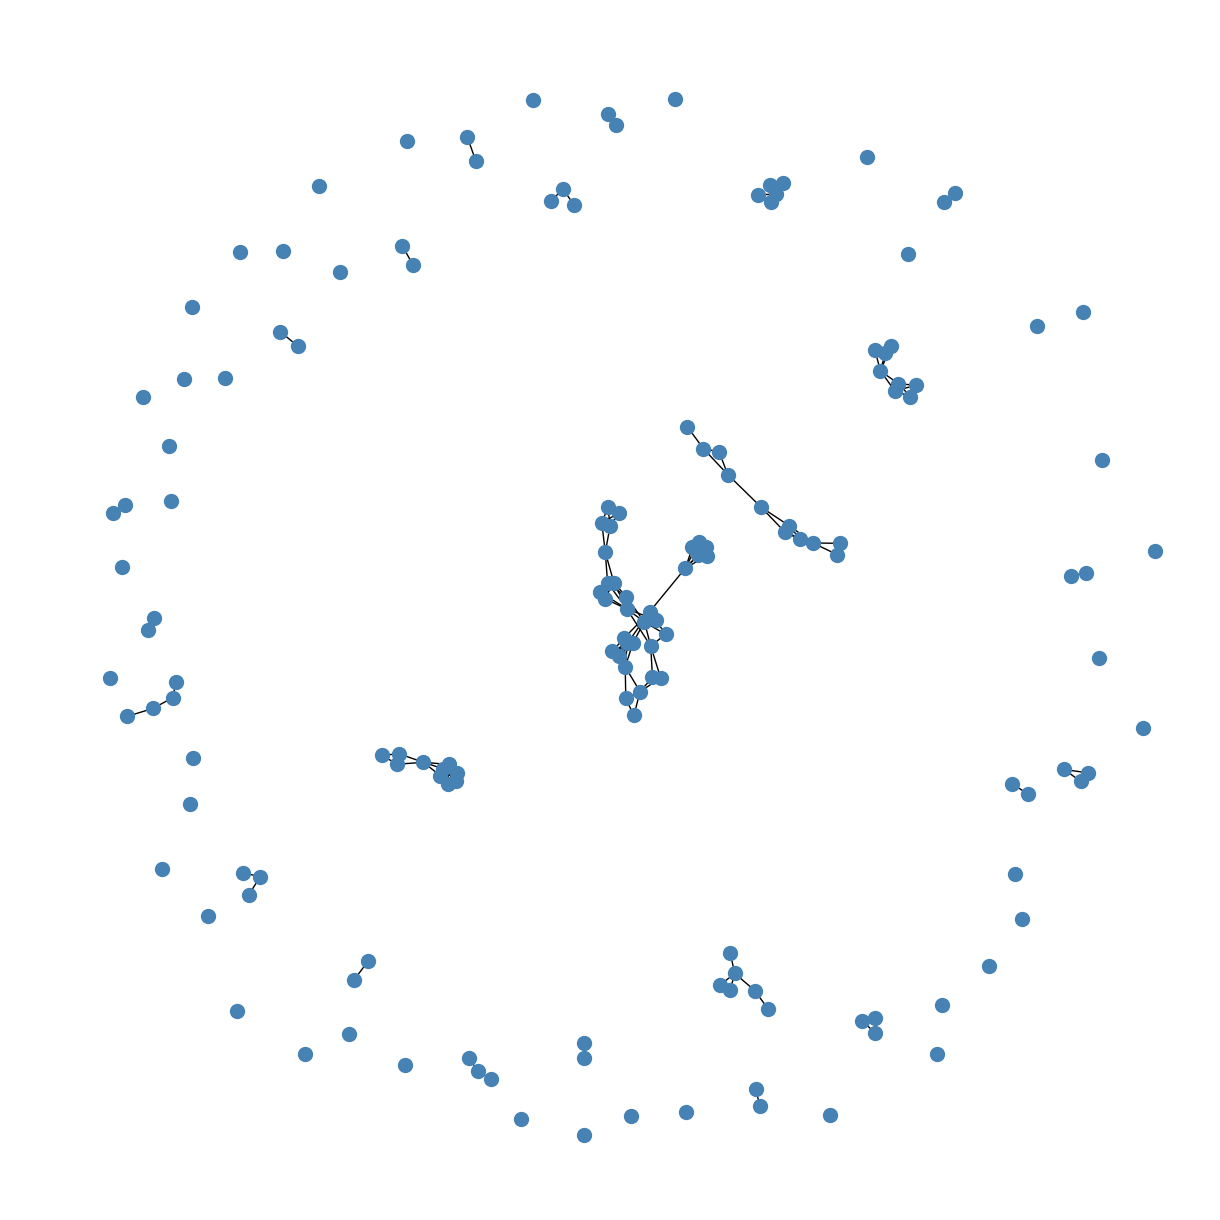

In [48]:
# pos = nx.get_node_attributes(G, 'pos')

tumor_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'Tumor']
tumor_graph = G.subgraph(tumor_nodes)

pos = nx.spring_layout(tumor_graph)

plt.figure(figsize=(12, 12))
nx.draw(tumor_graph, pos, node_size=100, node_color='steelblue')
plt.show()